This notebook is supposed to be similar to the other analyze xgboost, but takes into account all gene importances, not just the top three and the last as in `analyze_xgboost_binary_gain.ipynb`

In [1]:
import pandas as pd
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from Bio import SeqIO
import os
import numpy as np
from glob import glob
from matplotlib.colors import SymLogNorm
from scipy.cluster.hierarchy import linkage, leaves_list

data = "1100"

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["figure.figsize"] = (5, 3)

#path = '/pfs/work7/workspace/scratch/tu_kmpaj01-link'
path = '../../'

/var/folders/08/0076z2nx1y7bs97dcwb0_4ym0000gq/T/ipykernel_5919/160736487.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
ip_names = pd.read_csv("https://ftp.ebi.ac.uk/pub/databases/interpro/current_release/entry.list",sep="\t",header=0)
ip_names.set_index("ENTRY_AC",inplace=True)

ip_names["ENTRY_NAME"] = ip_names["ENTRY_NAME"].str.replace("[","_").str.replace("]","_").str.replace("<","_")

rels =	[i.split("/")[-1].split(".")[0] for i in glob(f"{path}/xgboost/annotations{data}/*.pkl")]

In [3]:
ip2go = pd.read_csv("https://ftp.ebi.ac.uk/pub/databases/interpro/current_release/interpro2go", sep="\t", skiprows=5, header=None, names=["raw"])
ip2go[['InterPro', 'Description', 'GO_description',"GO_id"]] = ip2go['raw'].str.extract(r'InterPro:(IPR\d+)\s+(.+?)\s+>\s+GO:(.+)\s;\s(.+)')
ip2go.drop(columns=['raw'], inplace=True)
ip2go["Description"] = ip2go["Description"].str.replace("[","_").str.replace("]","_").str.replace("<","_")

### Read in the data

In [4]:
with open(f"{path}/xgboost/annotations{data}/binary/binary.pkl", 'rb') as f:
	d = pickle.load(f)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:39:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1722454156233/work/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [5]:
l = []
for rel in tqdm(rels):
	for i in range(len(d[rel])):
		s = pd.Series(d[rel][i][2].get_score(importance_type="gain"))
		if len(s) > 0:
			importance_values = s.sort_values(ascending=False).values
			genes = s.sort_values(ascending=False).index.to_list()
			importance_ranking = s.sort_values(ascending=False).rank(ascending=False).values
			accuracy = d[rel][i][1]
			ner = d[rel][i][0][0]
			for j in range(len(importance_values)):
				l.append([rel, ner,genes[j], importance_values[j], importance_ranking[j],accuracy])


  0%|          | 0/17 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame(l, columns=["rel","ner","gene","importance_values","importance_ranking","accuracy"])

In [8]:
from goatools import obo_parser
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.obo_parser import GODag
import os

# Load GO ontology
obo_filepath = os.path.join(os.getcwd(), "go-basic.obo")
if not os.path.exists(obo_filepath):
    !wget http://purl.obolibrary.org/obo/go/go-basic.obo
obo_dag = GODag("go-basic.obo")

# Create a dictionary mapping genes to GO terms
gene_to_go = {}
for _, row in ip2go.iterrows():
    gene = row['Description']
    go_id = row['GO_id']
    if gene not in gene_to_go:
        gene_to_go[gene] = set()
    gene_to_go[gene].add(go_id)

# Get all genes (population)
population = set(df['gene'].unique())

# Perform GO enrichment for each unique rel
go_enrichment_results = []

for rel in df['rel'].unique():
    # Get study genes (genes specific to this rel)
    study_genes = set(df[df['rel'] == rel]['gene'].unique())
    
    # Create GOEnrichmentStudy object
    g = GOEnrichmentStudy(
        population,
        gene_to_go,
        obo_dag,
        propagate_counts=False,
        alpha=0.05,
        methods=['fdr_bh']
    )
    
    # Run GO enrichment analysis
    go_results = g.run_study(study_genes)
    
    # Store results
    for r in go_results:
        if r.p_fdr_bh < 0.05:  # Only consider statistically significant results
            go_enrichment_results.append({
                'rel': rel,
                'go_id': r.GO,
                'go_term': r.name,
                'p_value': r.p_uncorrected,
                'p_fdr_bh': r.p_fdr_bh,
                'enrichment': r.enrichment,
                'study_count': r.study_count,
                'study_n': r.study_n,
                'pop_count': r.pop_count,
                'pop_n': r.pop_n,
                'depth': r.depth
            })

# Convert results to DataFrame
go_enrichment_df = pd.DataFrame(go_enrichment_results)

# Sort and display results
go_enrichment_df = go_enrichment_df.sort_values(['rel', 'p_fdr_bh'])

# Optionally, save results to a CSV file
#go_enrichment_df.to_csv("go_enrichment_results.csv", index=False)

go-basic.obo: fmt(1.2) rel(2024-06-17) 45,494 Terms

Load  Ontology Enrichment Analysis ...
 22%  2,652 of 12,213 population items found in association

Runing  Ontology Analysis: current study set of 5038 IDs.
 28%  1,419 of  5,038 study items found in association
100%  5,038 of  5,038 study items found in population(12213)
Calculating 1,524 uncorrected p-values using fisher_scipy_stats
   1,524 terms are associated with  2,652 of 12,213 population items
     928 terms are associated with  1,419 of  5,038 study items
  METHOD fdr_bh:
      17 GO terms found significant (< 0.05=alpha) ( 14 enriched +   3 purified): statsmodels fdr_bh
     577 study items associated with significant GO IDs (enriched)
      13 study items associated with significant GO IDs (purified)

Load  Ontology Enrichment Analysis ...
 22%  2,652 of 12,213 population items found in association

Runing  Ontology Analysis: current study set of 7182 IDs.
 26%  1,868 of  7,182 study items found in association
100%  7,18

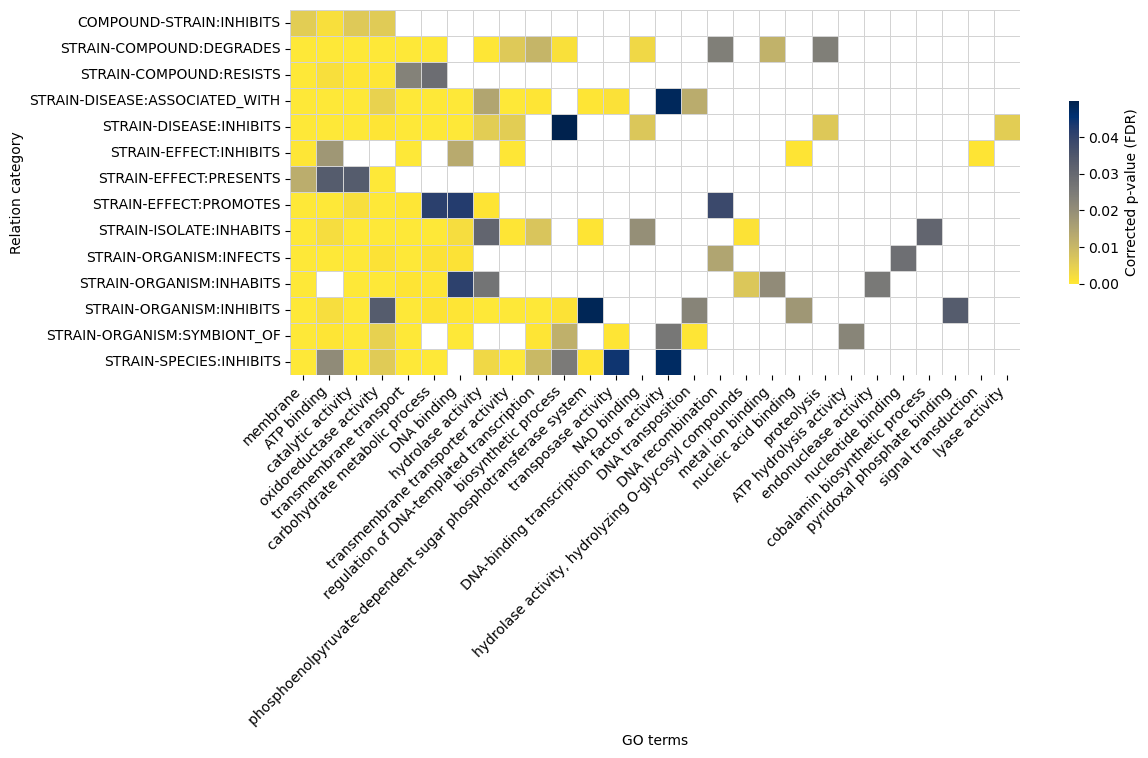

In [8]:
# Pivot the dataframe to create a matrix
pivot_df = go_enrichment_df[go_enrichment_df["enrichment"]=="e"].pivot(index='rel', columns='go_term', values='p_fdr_bh')

# Replace NaN values with 1 (least significant p-value)
pivot_df = pivot_df.fillna(1)

# Order the GO terms by the number of rels they are significant in
go_term_order = pivot_df.apply(lambda x: (x <= 0.05).sum(), axis=0).sort_values(ascending=False).index
pivot_df = pivot_df[go_term_order]

# Create a mask for p-values > 0.05 (not significant)
mask = pivot_df > 0.05

# Plot the heatmap
plt.figure(figsize=(13, 7))
sns.heatmap(pivot_df, 
            cmap='cividis_r',
            mask=mask,  # Mask non-significant values
            cbar_kws={'label': 'Corrected p-value (FDR)', 'shrink': 0.5},  # Make the color bar smaller
            xticklabels=True,
            yticklabels=True,
            square=True, 
            linewidths=0.5,
            linecolor="lightgrey")  # Draw the grid

#plt.title('GO Term Enrichment Significance by Relation Type')
plt.xlabel('GO terms')
plt.ylabel('Relation category')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("figures/xgboost/xgboost_go_enrichment.pdf", bbox_inches="tight")

In [9]:
df[df["importance_ranking"]==1].value_counts("rel")

rel
STRAIN-COMPOUND:PRODUCES          1133
COMPOUND-STRAIN:INHIBITS          1092
STRAIN-MEDIUM:GROWS_ON             922
STRAIN-PHENOTYPE:PRESENTS          641
STRAIN-EFFECT:PRESENTS             353
STRAIN-COMPOUND:RESISTS            289
STRAIN-EFFECT:PROMOTES             220
STRAIN-ORGANISM:INFECTS            208
STRAIN-DISEASE:INHIBITS            170
STRAIN-ORGANISM:INHABITS           146
STRAIN-COMPOUND:DEGRADES            78
STRAIN-ISOLATE:INHABITS             57
STRAIN-DISEASE:ASSOCIATED_WITH      56
STRAIN-ORGANISM:INHIBITS            55
STRAIN-SPECIES:INHIBITS             35
STRAIN-ORGANISM:SYMBIONT_OF         14
STRAIN-EFFECT:INHIBITS               5
Name: count, dtype: int64

In [10]:
df.sort_values("importance_values")

,rel,ner,gene,importance_values,importance_ranking,accuracy
623456,COMPOUND-STRAIN:INHIBITS,strontium,Pentapeptide repeat,0.000001,79.0,0.999751
629366,COMPOUND-STRAIN:INHIBITS,cysteamine,Protein of unknown function DUF4406,0.000001,88.0,0.999779
1192235,STRAIN-COMPOUND:PRODUCES,mcl-,"Transcription regulator LuxR, C-terminal",0.000001,165.0,0.999589
1514293,STRAIN-MEDIUM:GROWS_ON,spizizen's minimal,"Alpha-D-phosphohexomutase, alpha/beta/alpha do...",0.000001,140.0,0.999801
621480,COMPOUND-STRAIN:INHIBITS,rhein,YjeF N-terminal domain,0.000001,127.0,0.999751
...,...,...,...,...,...,...
649527,STRAIN-DISEASE:INHIBITS,breast cancer,"Uncharacterised protein family, inner membrane...",193.600586,1.0,0.996476
175579,STRAIN-PHENOTYPE:PRESENTS,probiotic,"Peptidase C1B, bleomycin hydrolase",208.209671,3.0,0.980600
1246469,STRAIN-ORGANISM:INHIBITS,c. albicans,RICH domain,307.725586,1.0,0.974420
175578,STRAIN-PHENOTYPE:PRESENTS,probiotic,"Protein export membrane protein SecD/SecF, C-t...",309.583649,2.0,0.980600


In [11]:
df[(df["ner"]!= "c")&(df["ner"]!= "l-")].sort_values("importance_values",ascending=False).to_csv("xgboost_files/gene_importances.csv",index=False)

In [12]:
# write file for figure with importance values higher than 20
df[(df["ner"]!= "c")&(df["ner"]!= "l-")&(df["importance_values"] > 20)].sort_values("importance_values",ascending=False).loc[:,["rel","ner","gene","importance_values","accuracy","importance_ranking"]].round({"importance_values": 2, "accuracy": 2}).to_excel("xgboost_files/gene_importances_high.xlsx",index=False)

In [13]:
df[(df["rel"]== "STRAIN-ORGANISM:INFECTS")].sort_values("importance_values",ascending=False).to_csv("xgboost_files/gene_importances_infects.csv",index=False)

In [14]:
# write file for figure with importance values higher than 20 for infects only
df[(df["rel"]== "STRAIN-ORGANISM:INFECTS")&(df["importance_values"] > 10)].sort_values("importance_values",ascending=False).loc[:,["ner","gene","importance_values","accuracy","importance_ranking"]].round({"importance_values": 2, "accuracy": 2}).to_excel("xgboost_files/gene_importances_high_infects.xlsx",index=False)

### Host association

In [15]:
df

,rel,ner,gene,importance_values,importance_ranking,accuracy
0,STRAIN-ISOLATE:INHABITS,patient,"Galactose-1-phosphate uridyl transferase, N-te...",103.387573,1.0,0.948962
1,STRAIN-ISOLATE:INHABITS,patient,Domain of unknown function with cystatin-like ...,75.699860,2.0,0.948962
2,STRAIN-ISOLATE:INHABITS,patient,YSIRK Gram-positive signal peptide,68.305252,3.0,0.948962
3,STRAIN-ISOLATE:INHABITS,patient,"Adenylyl/Guanylyl and SMODS, C-terminal sensor...",32.874836,4.0,0.948962
4,STRAIN-ISOLATE:INHABITS,patient,Type I restriction enzyme HindI endonuclease s...,29.867764,5.0,0.948962
...,...,...,...,...,...,...
1567885,STRAIN-ORGANISM:INHABITS,t,HTH-type transcriptional regulator MT1864/Rv18...,0.024340,326.0,0.998843
1567886,STRAIN-ORGANISM:INHABITS,t,RmlD-like substrate binding domain,0.012887,327.0,0.998843
1567887,STRAIN-ORGANISM:INHABITS,t,"2-isopropylmalate synthase LeuA, allosteric (d...",0.004809,328.0,0.998843
1567888,STRAIN-ORGANISM:INHABITS,t,"Peptidyl-prolyl cis-trans isomerase, PpiC-type",0.002868,329.0,0.998843


In [16]:
oi = df[df["rel"]=="STRAIN-ORGANISM:INHABITS"]

In [17]:
common_genes = df.groupby("ner")["gene"].apply(set).reset_index()
common_genes = common_genes[common_genes["ner"].duplicated(keep=False)]

In [20]:
oiforheat = oi

oiforheat["ner"] = oiforheat.ner.str.replace("piglets", "piglet").replace("maize plants","maize").replace("tomato plants","tomato")
# Remove non-informative ners and merge duplicated
to_filter_out = ["plants", "poultry", "plant"]
filtered_oi = oiforheat[~oiforheat['ner'].isin(to_filter_out)]

# Apply importance cutoff
importance_cutoff = 15
filtered_oi = filtered_oi[filtered_oi['importance_values'] > importance_cutoff]
filtered_oi.ner.unique()

/var/folders/08/0076z2nx1y7bs97dcwb0_4ym0000gq/T/ipykernel_5919/2050756632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oiforheat["ner"] = oiforheat.ner.str.replace("piglets", "piglet").replace("maize plants","maize").replace("tomato plants","tomato")


array(['human', 'mouse', 'chicken', 'pig', 'rice', 'bovine', 'tomato',
       'fish', 'potato', 'sheep', 'infant', 'mosquito', 'volunteers',
       'soybean', 'laying hens', 'fungal', 'piglet', 'human volunteers',
       '3d7', 'plasmodium falciparum', 'p. falciparum', 'equus caballus',
       'galleria mellonella larvae', 'ticks'], dtype=object)

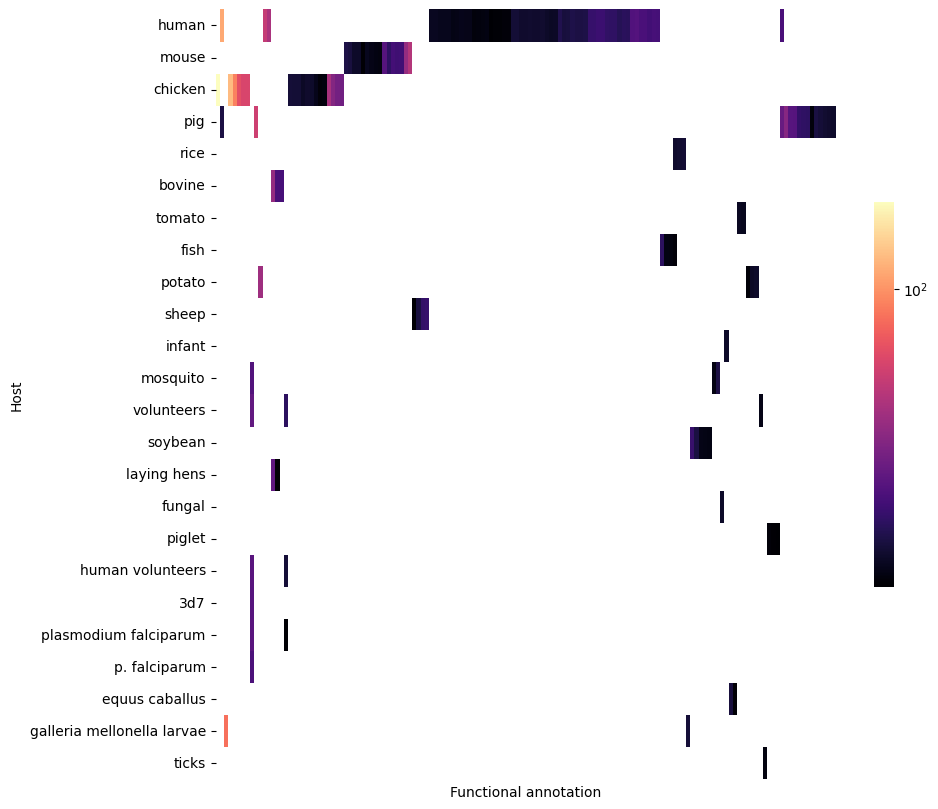

In [21]:
genes_occurrence = filtered_oi['gene'].value_counts()
genes_several = genes_occurrence.index.tolist()
filtered_oi = filtered_oi[filtered_oi['gene'].isin(genes_several)]

# Pivot the dataframe to create a matrix for the heatmap
heatmap_data = filtered_oi.pivot_table(index='ner', columns='gene', values='importance_values', aggfunc='max')

# Drop all columns with no values
heatmap_data = heatmap_data.dropna(how='all', axis=1)

# Specify the order of organisms
#order_ner = ["potato", "tomato", "rice", "wheat", "maize","mouse","sheep", "cattle", "piglet","pig", "dog", "chicken"]
order_ner = ['human', 'mouse', 'chicken', 'pig', 'rice', 'bovine', 'tomato',
       'fish', 'potato', 'sheep', 'infant', 'mosquito', 'volunteers',
       'soybean', 'laying hens', 'fungal', 'piglet', 'human volunteers',
       '3d7', 'plasmodium falciparum', 'p. falciparum', 'equus caballus',
       'galleria mellonella larvae', 'ticks']

# Reorder heatmap_data to match the specified order of organisms
heatmap_data = heatmap_data.loc[order_ner]

# Clustering on genes
linkage_matrix = linkage(heatmap_data.T.fillna(0), method='average')
ordered_indices = leaves_list(linkage_matrix)
ordered_genes = heatmap_data.columns[ordered_indices]

# Remove genes that are all na
ordered_genes = ordered_genes[~heatmap_data[ordered_genes].isna().all()]

# Reorder heatmap_data according to clustering of genes
heatmap_data = heatmap_data[ordered_genes]

# Create the heatmap with log color mapping
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, cmap='magma', annot=False, fmt=".2f", cbar=True, xticklabels=False, cbar_kws={'shrink': 0.5}, norm=SymLogNorm(linthresh=0.01))

plt.ylabel('Host')
plt.xlabel('Functional annotation')
plt.savefig("figures/xgboost/xgboost_heatmap_cluster_inhabits.pdf", bbox_inches="tight")

/var/folders/08/0076z2nx1y7bs97dcwb0_4ym0000gq/T/ipykernel_5919/1941254114.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.clustermap(heatmap_data.fillna(0).applymap(lambda x: 1 if x != 0 else 0),figsize=(10,10))


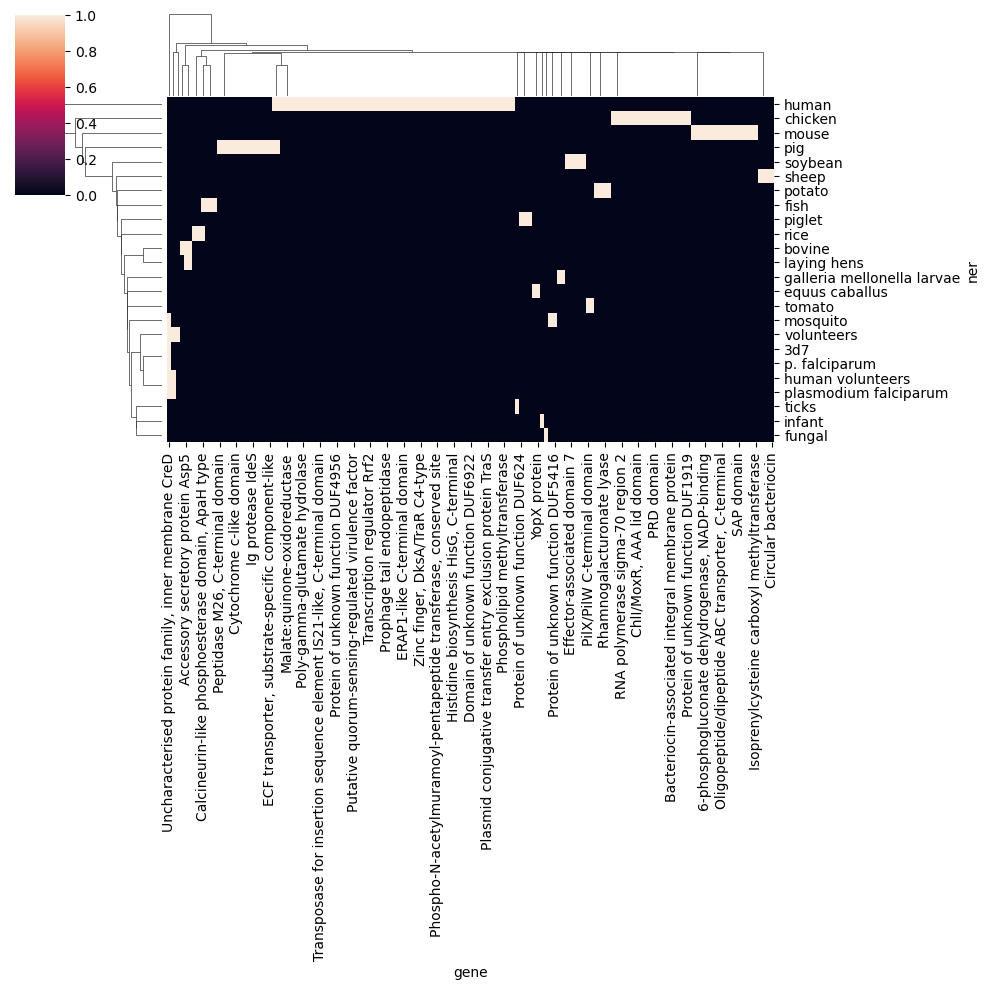

In [22]:
sns.clustermap(heatmap_data.fillna(0).applymap(lambda x: 1 if x != 0 else 0),figsize=(10,10))

#### Check for evolution on these genes

In [23]:
genes_to_check = heatmap_data.T.index

### Infection

In [24]:
oi = df[df["rel"]=="STRAIN-ORGANISM:INFECTS"]

In [25]:
oiforheat = oi

oiforheat["ner"] = oiforheat.ner.str.replace("piglets", "piglet").replace("maize plants","maize").replace("tomato plants","tomato").replace("ferrets","ferret").replace("anopheles stephensi mosquitoes","anopheles stephensi").replace("a. stephensi","anopheles stephensi")
# Remove non-informative ners and merge duplicated
to_filter_out = ["plants", "poultry", "plant"]
filtered_oi = oiforheat[~oiforheat['ner'].isin(to_filter_out)]

# Apply importance cutoff
importance_cutoff = 15
filtered_oi = filtered_oi[filtered_oi['importance_values'] > importance_cutoff]
filtered_oi.ner.unique()

/var/folders/08/0076z2nx1y7bs97dcwb0_4ym0000gq/T/ipykernel_5919/680127392.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oiforheat["ner"] = oiforheat.ner.str.replace("piglets", "piglet").replace("maize plants","maize").replace("tomato plants","tomato").replace("ferrets","ferret").replace("anopheles stephensi mosquitoes","anopheles stephensi").replace("a. stephensi","anopheles stephensi")


array(['mouse', 'human', 'balb/c mice', 'larvae', 'galleria mellonella',
       'old', 'pig', 'caenorhabditis elegans', 'animals',
       'galleria mellonella larvae', 'rabbit', 'hela', 'fish', 'larval',
       'mosquito', 'nematodes', 'wild-type', 'd. melanogaster',
       'zebrafish embryos', 'pups', 'ferret', 'mdck', 'humanized mice',
       'insect', 'chinchillas', 'chimpanzee', 'white-tailed deer',
       'p. falciparum', 'p. plantaginis', 'wheat', 'patients', '293'],
      dtype=object)

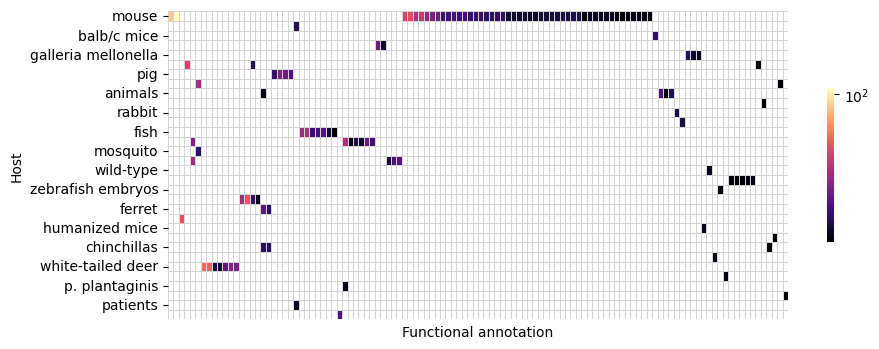

In [26]:
genes_occurrence = filtered_oi['gene'].value_counts()
genes_several = genes_occurrence.index.tolist()
filtered_oi = filtered_oi[filtered_oi['gene'].isin(genes_several)]

# Pivot the dataframe to create a matrix for the heatmap
heatmap_data = filtered_oi.pivot_table(index='ner', columns='gene', values='importance_values', aggfunc='max')

# Drop all columns with no values
heatmap_data = heatmap_data.dropna(how='all', axis=1)

# Specify the order of organisms
# order_ner = ["potato", "tomato", "rice", "wheat","mouse","sheep", "cattle", "piglet","pig", "dog", "chicken"]
#order_ner = [ "bean plants","tomato","wheat","pig", "dog","rabbit","ferret","white-tailed deer", "chicken","galleria mellonella","anopheles stephensi","d. melanogaster","drosophila melanogaster","p. plantaginis","monkey","chimpanzee","caenorhabditis elegans","rainbow trout","mouse","human"]
order_ner = ['mouse', 'human', 'balb/c mice', 'larvae', 'galleria mellonella',
       'old', 'pig', 'caenorhabditis elegans', 'animals',
       'galleria mellonella larvae', 'rabbit', 'hela', 'fish', 'larval',
       'mosquito', 'nematodes', 'wild-type', 'd. melanogaster',
       'zebrafish embryos', 'pups', 'ferret', 'mdck', 'humanized mice',
       'insect', 'chinchillas', 'chimpanzee', 'white-tailed deer',
       'p. falciparum', 'p. plantaginis', 'wheat', 'patients', '293']
heatmap_data = heatmap_data.loc[order_ner]

# Clustering on genes
linkage_matrix = linkage(heatmap_data.T.fillna(0), method='average')
ordered_indices = leaves_list(linkage_matrix)
ordered_genes = heatmap_data.columns[ordered_indices]

# Remove genes that are all na
ordered_genes = ordered_genes[~heatmap_data[ordered_genes].isna().all()]

# Reorder heatmap_data according to clustering of genes
heatmap_data = heatmap_data[ordered_genes]

# Create the heatmap with log color mapping
plt.figure(figsize=(10, 4))
sns.heatmap(heatmap_data, cmap='magma', annot=False, fmt=".2f", cbar=True, xticklabels=False, cbar_kws={'shrink': 0.5}, norm=SymLogNorm(linthresh=0.01), linewidths=.5, linecolor='lightgray')

plt.ylabel('Host')
plt.xlabel('Functional annotation')
plt.savefig("figures/xgboost/xgboost_heatmap_cluster_infects.pdf", bbox_inches="tight")

### Phenotypic traits

---

In [27]:
df

,rel,ner,gene,importance_values,importance_ranking,accuracy
0,STRAIN-ISOLATE:INHABITS,patient,"Galactose-1-phosphate uridyl transferase, N-te...",103.387573,1.0,0.948962
1,STRAIN-ISOLATE:INHABITS,patient,Domain of unknown function with cystatin-like ...,75.699860,2.0,0.948962
2,STRAIN-ISOLATE:INHABITS,patient,YSIRK Gram-positive signal peptide,68.305252,3.0,0.948962
3,STRAIN-ISOLATE:INHABITS,patient,"Adenylyl/Guanylyl and SMODS, C-terminal sensor...",32.874836,4.0,0.948962
4,STRAIN-ISOLATE:INHABITS,patient,Type I restriction enzyme HindI endonuclease s...,29.867764,5.0,0.948962
...,...,...,...,...,...,...
1567885,STRAIN-ORGANISM:INHABITS,t,HTH-type transcriptional regulator MT1864/Rv18...,0.024340,326.0,0.998843
1567886,STRAIN-ORGANISM:INHABITS,t,RmlD-like substrate binding domain,0.012887,327.0,0.998843
1567887,STRAIN-ORGANISM:INHABITS,t,"2-isopropylmalate synthase LeuA, allosteric (d...",0.004809,328.0,0.998843
1567888,STRAIN-ORGANISM:INHABITS,t,"Peptidyl-prolyl cis-trans isomerase, PpiC-type",0.002868,329.0,0.998843


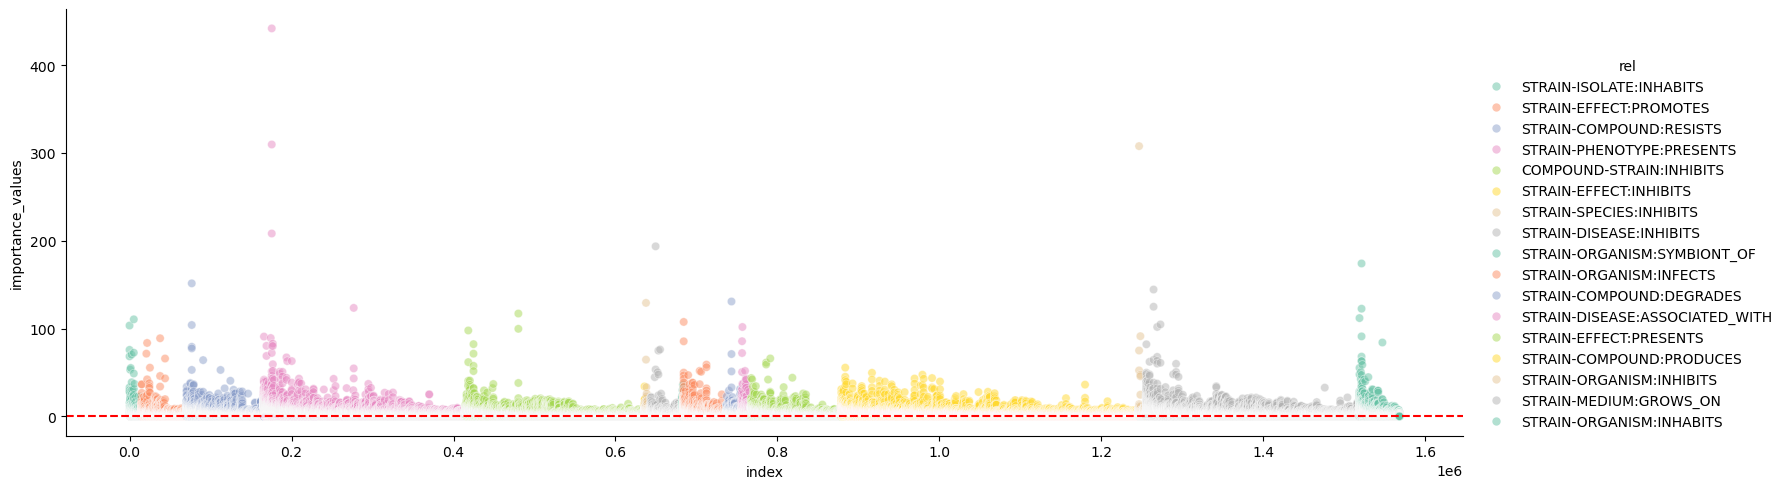

In [28]:
sns.relplot(y="importance_values", x="index", hue="rel", data=df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

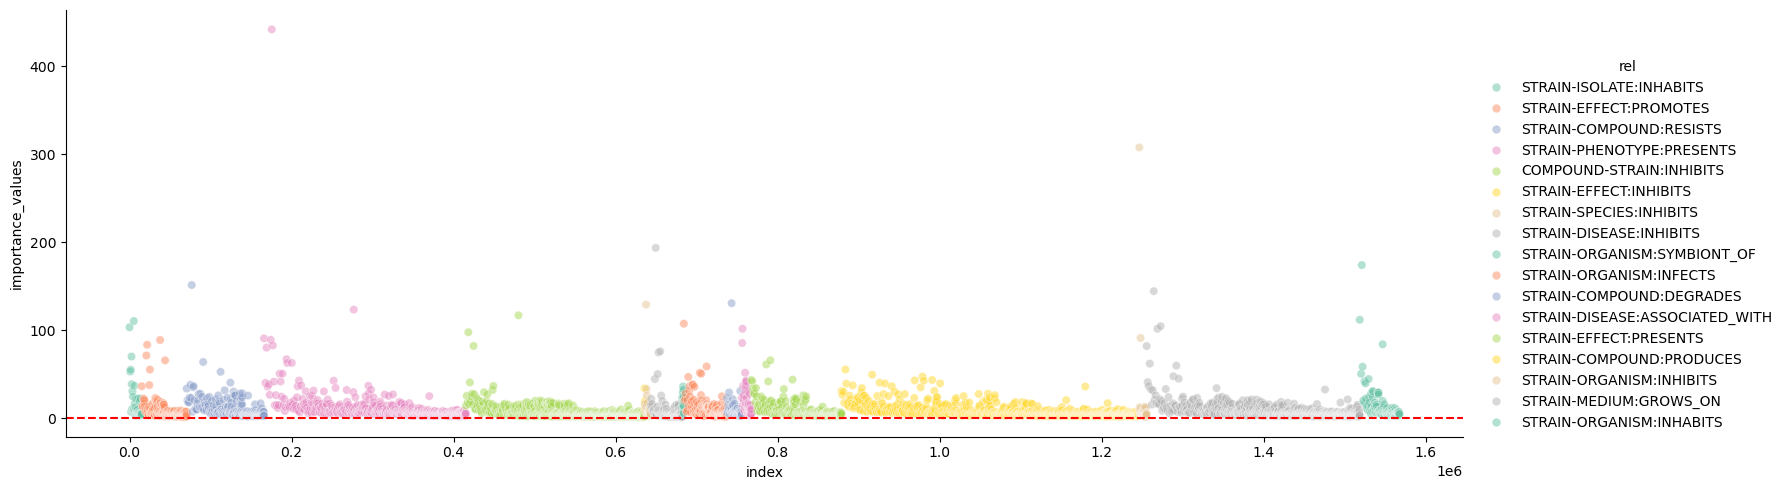

In [29]:
sns.relplot(y="importance_values", x="index", hue="rel", data=df[df["importance_ranking"]==1].reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

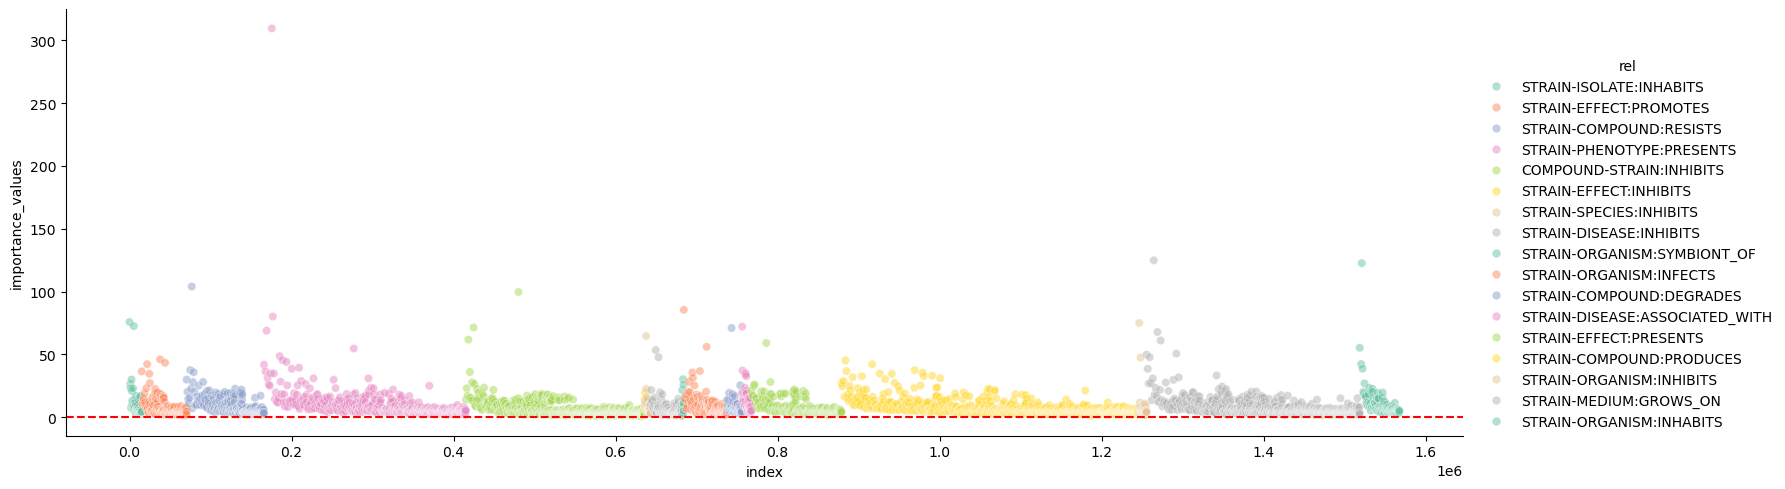

In [30]:
sns.relplot(y="importance_values", x="index", hue="rel", data=df[df["importance_ranking"]==2].reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

add value counts and check whether these play a role in the value significance. if it does, we could consider normalizing by this value

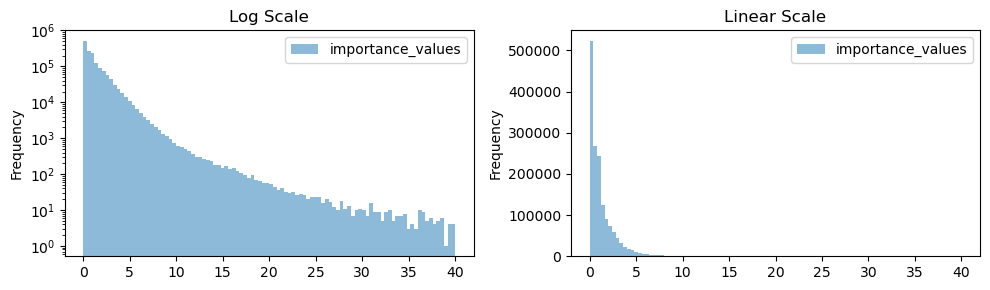

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
df.plot(kind='hist',y="importance_values",bins=100,range=(0,40),alpha=0.5, ax=ax[0])
df.plot(kind='hist',y="importance_values",bins=100,range=(0,40),alpha=0.5, ax=ax[1])
ax[0].set_yscale("log")
ax[0].set_title('Log Scale')
ax[1].set_title('Linear Scale')
plt.tight_layout()


#### Group by function

In [32]:
df.value_counts("gene")

gene
Integrase, catalytic core                      4094
Integrase, catalytic domain                    4021
ABC transporter-like, ATP-binding domain       3896
Cro/C1-type helix-turn-helix domain            3470
Transposase IS4-like domain                    3394
                                               ... 
Large ribosomal subunit protein eL22              1
Protein of unknown function DUF4295               1
Domain of unknown function DUF5603                1
Uncharacterised conserved protein UCP037692       1
Protein of unknown function DUF6276               1
Name: count, Length: 12213, dtype: int64

In [101]:
df[df["gene"]=="Integrase, catalytic core"]

,rel,ner,gene,importance_values,importance_ranking,accuracy
77,STRAIN-ISOLATE:INHABITS,patient,"Integrase, catalytic core",6.116112,78.0,0.948962
1500,STRAIN-ISOLATE:INHABITS,blood of,"Integrase, catalytic core",5.874728,23.0,0.976067
2299,STRAIN-ISOLATE:INHABITS,year,"Integrase, catalytic core",1.827896,380.0,0.982987
3181,STRAIN-ISOLATE:INHABITS,wastewater treatment plant,"Integrase, catalytic core",2.064987,81.0,0.990773
3726,STRAIN-ISOLATE:INHABITS,blood sample,"Integrase, catalytic core",1.576100,212.0,0.995098
...,...,...,...,...,...,...
1565867,STRAIN-ORGANISM:INHABITS,legume,"Integrase, catalytic core",0.625267,118.0,0.998699
1566603,STRAIN-ORGANISM:INHABITS,algae,"Integrase, catalytic core",0.242955,303.0,0.998843
1566763,STRAIN-ORGANISM:INHABITS,healthy human subjects,"Integrase, catalytic core",0.024891,130.0,0.998843
1566920,STRAIN-ORGANISM:INHABITS,d. discoideum,"Integrase, catalytic core",0.068814,129.0,0.998843


#### Calculate number of assemblies per NER

TODO: Calculate also species per NER?

In [33]:
assemblies_perner = []
for rel in tqdm(rels):
	d[rel]= []
	filepath = f"{path}/xgboost/annotations{data}/{rel}.pkl"
	# Read the pickle file
	with open(filepath, "rb") as f:
		dat = pickle.load(f)
	vc = pd.DataFrame(pd.DataFrame(dat[1]).value_counts())
	vc["rel"] = rel
	assemblies_perner.append(vc)
	

  0%|          | 0/17 [00:00<?, ?it/s]

In [34]:
assemblies = pd.concat(assemblies_perner)

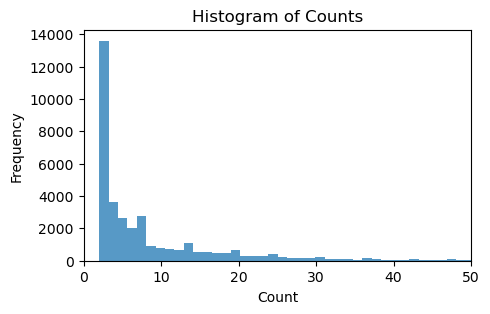

In [35]:
assemblies['count'].plot(kind='hist', bins=3000, alpha=0.75)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Histogram of Counts')
plt.xlim(0,50)
plt.show()

In [36]:
merged_df = df.merge(assemblies,left_on=["rel","ner"],right_on=["rel",0])

In [37]:
merged_df.sort_values("count")

,rel,ner,gene,importance_values,importance_ranking,accuracy,count
1567889,STRAIN-ORGANISM:INHABITS,t,Oleate hydratase,0.000430,330.0,0.998843,21
411615,STRAIN-PHENOTYPE:PRESENTS,yellowish,"Glycosyltransferase 61, catalytic domain",0.011280,266.0,0.999761,21
411614,STRAIN-PHENOTYPE:PRESENTS,yellowish,"ATP-dependent RecD2 DNA helicase-like, helix-h...",0.011501,265.0,0.999761,21
411613,STRAIN-PHENOTYPE:PRESENTS,yellowish,"Malic enzyme, NAD-binding",0.011753,264.0,0.999761,21
411612,STRAIN-PHENOTYPE:PRESENTS,yellowish,Protein of unknown function DUF4160,0.012612,263.0,0.999761,21
...,...,...,...,...,...,...,...
166801,STRAIN-PHENOTYPE:PRESENTS,biofilm,"ATP-dependent DNA helicase RecG, C-terminal do...",6.545763,827.0,0.956873,3638
166800,STRAIN-PHENOTYPE:PRESENTS,biofilm,DNA polymerase III alpha subunit finger domain,6.551802,826.0,0.956873,3638
166799,STRAIN-PHENOTYPE:PRESENTS,biofilm,"Peptidase S33 tripeptidyl aminopeptidase-like,...",6.554850,825.0,0.956873,3638
166797,STRAIN-PHENOTYPE:PRESENTS,biofilm,"Resolvase, N-terminal catalytic domain",6.558000,823.0,0.956873,3638


/var/folders/08/0076z2nx1y7bs97dcwb0_4ym0000gq/T/ipykernel_5919/963669256.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(y="importance_values", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)


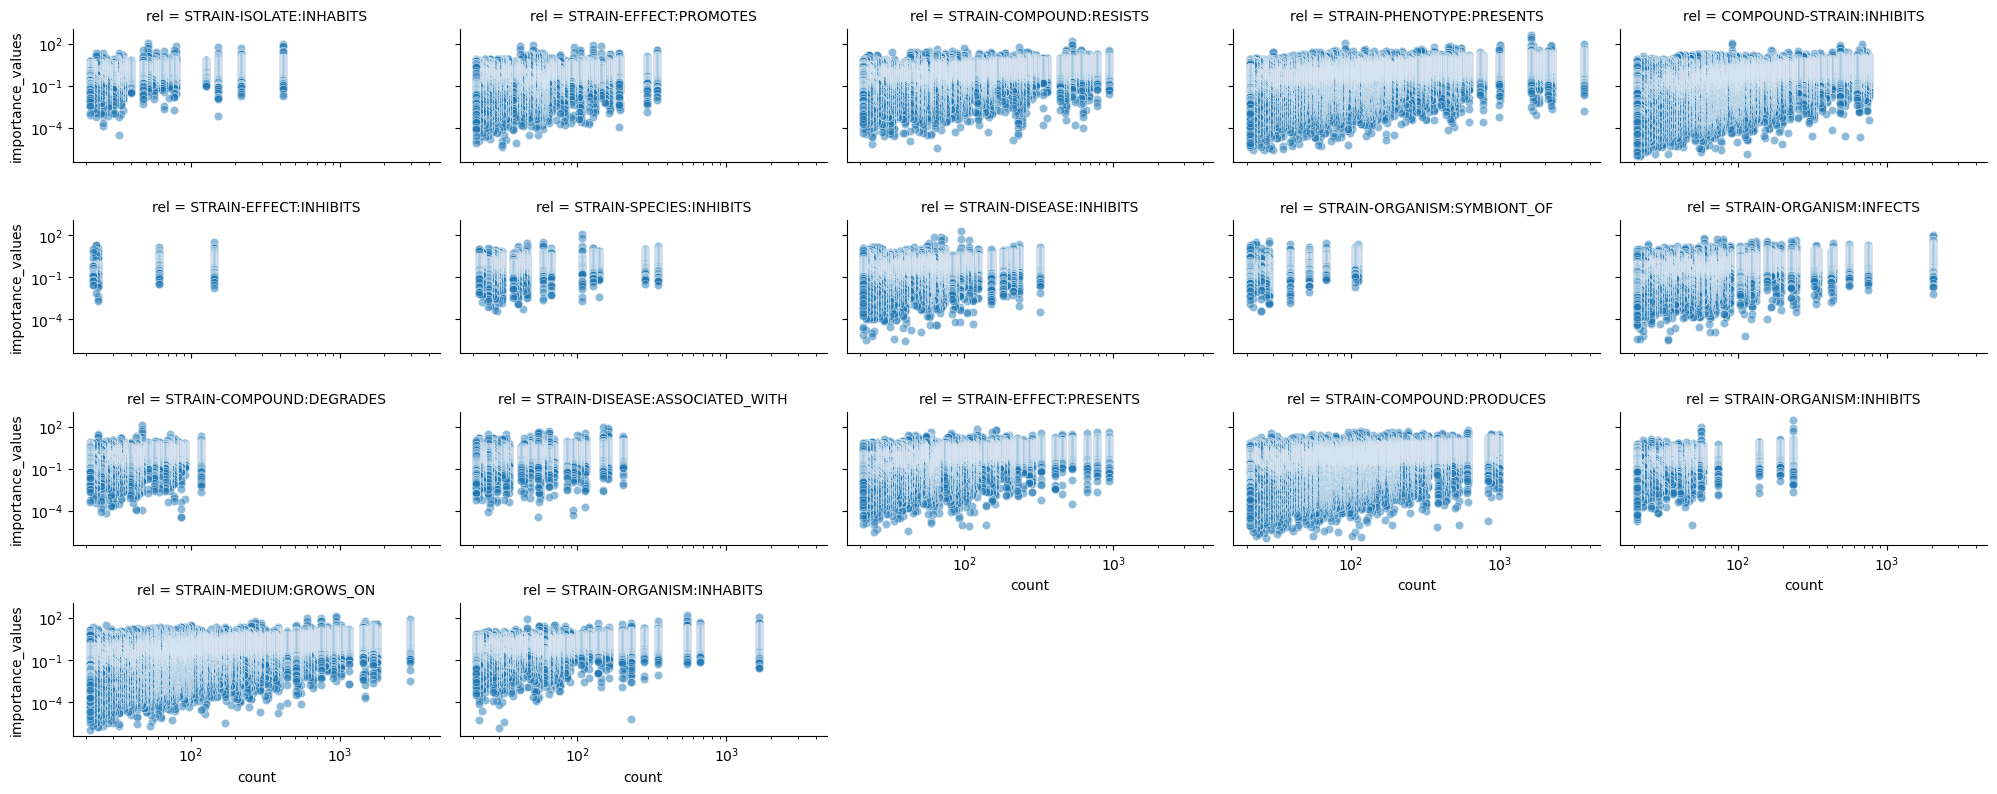

In [38]:
sns.relplot(y="importance_values", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)
plt.xscale("log")
plt.yscale("log")

#### Try to normalize by the number of assemblies per NER

In [39]:
merged_df['normalized_value'] = (merged_df['importance_values'] / merged_df['count'])

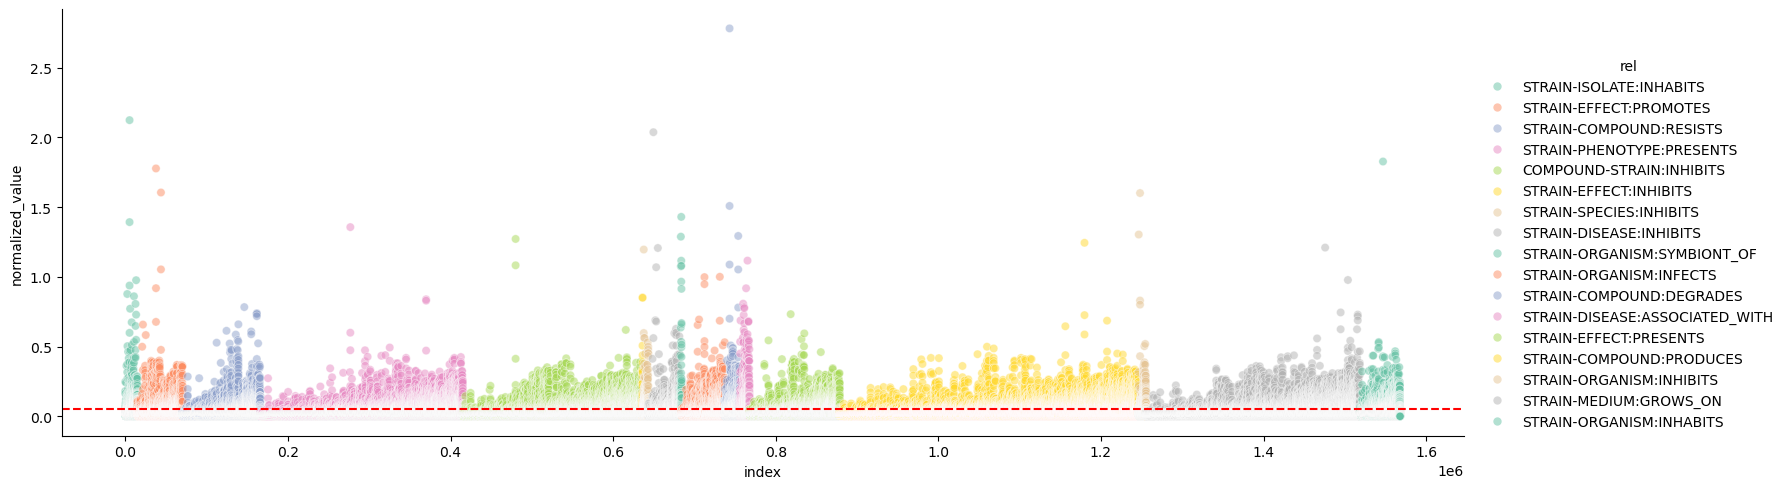

In [40]:
sns.relplot(y="normalized_value", x="index", hue="rel", data=merged_df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.05, color='r', linestyle='--')

In [44]:
merged_df.sort_values("normalized_value",ascending=False).head(20)

,rel,ner,gene,importance_values,importance_ranking,accuracy,count,normalized_value
743222,STRAIN-COMPOUND:DEGRADES,pa,NRAMP family,130.777298,1.0,0.998944,47,2.782496
5255,STRAIN-ISOLATE:INHABITS,cf patients,PAAR motif,110.467545,1.0,0.998270,52,2.124376
649527,STRAIN-DISEASE:INHIBITS,breast cancer,"Uncharacterised protein family, inner membrane...",193.600586,1.0,0.996476,95,2.037901
1546900,STRAIN-ORGANISM:INHABITS,galleria mellonella larvae,"DprA, winged helix domain",84.068970,1.0,0.999422,46,1.827586
37747,STRAIN-EFFECT:PROMOTES,uptake,"UDP-glucose/GDP-mannose dehydrogenase, C-terminal",88.896729,1.0,0.999827,50,1.777935
43859,STRAIN-EFFECT:PROMOTES,larval survival,"Colicin D, C-terminal",65.822556,1.0,0.999827,41,1.605428
1248069,STRAIN-ORGANISM:INHIBITS,plasmodium falciparum,Domain of unknown function DUF5644,91.281624,1.0,0.998105,57,1.601432
743223,STRAIN-COMPOUND:DEGRADES,pa,DAHP synthetase I/KDSA,70.923798,2.0,0.998944,47,1.509017
683799,STRAIN-ORGANISM:SYMBIONT_OF,coral,YggL 50S ribosome-binding protein,32.905575,1.0,0.984901,23,1.430677
5256,STRAIN-ISOLATE:INHABITS,cf patients,Lysine-specific metallo-endopeptidase,72.436096,2.0,0.998270,52,1.393002


#### Find features where top three are very close

## Evolution

### Example (do not run)

In [45]:
merged_df.iloc[485]

rel                               STRAIN-ISOLATE:INHABITS
ner                                               patient
gene                  Protein of unknown function DUF6326
importance_values                                2.558631
importance_ranking                                  486.0
accuracy                                         0.948962
count                                                 418
normalized_value                                 0.006121
Name: 485, dtype: object

In [47]:
parq = pd.read_parquet(f"{path}/xgboost/annotations{data}/{merged_df.iloc[485].rel}.parquet")

In [64]:
strains = parq[parq["word_qc_group"]==merged_df.iloc[485].ner].sa_ner.str.split("!",expand=True)[0].unique()

In [53]:
protein_ids = parq[parq["InterPro_description"]== merged_df.iloc[485].gene].Protein_accession.unique()

In [70]:
output_faa = []
for s in strains:
	strain = s.replace(" ","_")
	# Check if the folder exists
	folder_path = f"{path}/assemblies_{data}/{strain}"
	if os.path.exists(folder_path):
		for assembly in os.listdir(folder_path):
			faa_files = glob(f"{folder_path}/{assembly}/*.faa")
			if faa_files:
				faa_file = faa_files[0]
				for record in SeqIO.parse(faa_file, "fasta"):
					if record.id in protein_ids:
						output_faa.append(record)

with open("test.faa","w") as f:
	SeqIO.write(output_faa, f, "fasta")

In [64]:
output_fna = []
for s in strains:
	strain = s.replace(" ","_")
	folder_path = f"{path}/assemblies_{data}/{strain}"
	if os.path.exists(folder_path):
		for assembly in os.listdir(folder_path):
			fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
			if fna_files:
				fna_file = fna_files[0]
				for record in SeqIO.parse(fna_file, "fasta"):
					if record.id in protein_ids:
						output_fna.append(record)
with open("test.fna","w") as f:
	SeqIO.write(output_fna, f, "fasta")

### Run for all rows in merged_df and save files into a folder each

In [28]:
outdir = f"{path}/seqfiles_{data}"
os.makedirs(outdir,exist_ok=True)
for rel in tqdm(merged_df['rel'].unique()):
	filtered_df = merged_df[merged_df['rel'] == rel]
	parq = pd.read_parquet(f"{path}/xgboost/annotations{data}/{rel}.parquet")
	for row in tqdm(filtered_df.iterrows(), total=len(filtered_df), leave=False):
		sa_ner = parq[parq["word_qc_group"]==row[1]['ner']].sa_ner
		if not sa_ner.empty:  # Use .empty to check if the Series is empty
			strains = sa_ner.str.split("!",expand=True)[0].unique()
			new_rel = row[1]['rel'].replace(':','_')
			new_ner = row[1]['ner'].replace(' ','_').replace("'",'').replace('(','_').replace(')','_')
			sa_ner = f"first_{new_rel}_{new_ner}"
			protein_ids = parq[parq["InterPro_description"]== row[1]['gene']].Protein_accession.unique()
			output_faa = []
			output_fna = []
			for s in strains:
				strain = s.replace(" ","_")
				folder_path = f"{path}/assemblies_{data}/{strain}"
				if os.path.exists(folder_path):
					for assembly in os.listdir(folder_path):
						faa_files = glob(f"{folder_path}/{assembly}/*.faa")
						fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
						if faa_files:
							faa_file = faa_files[0]
							for record in SeqIO.parse(faa_file, "fasta"):
								if record.id in protein_ids:
									record.description = ""
									output_faa.append(record)
						if fna_files:
							fna_file = fna_files[0]
							for record in SeqIO.parse(fna_file, "fasta"):
								if record.id in protein_ids:
									output_fna.append(record)
			os.makedirs(f"{outdir}/{sa_ner}",exist_ok=True)
			with open(f"{outdir}/{sa_ner}/seq.faa","w") as f:
				SeqIO.write(output_faa, f, "fasta")
			with open(f"{outdir}/{sa_ner}/seq.fna","w") as f:
				SeqIO.write(output_fna, f, "fasta")

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

### Create test set

In [29]:
# outdir = f"/home/gomez/gomez/seqfiles_linkbert_{data}_{max_assembly}"
# os.makedirs(outdir,exist_ok=True)
for rel in tqdm(merged_df['rel'].unique()):
	filtered_df = merged_df[merged_df['rel'] == rel]
	parq = pd.read_parquet(f"{path}/xgboost/annotations{data}/{rel}.parquet")
	for row in tqdm(filtered_df.iterrows(), total=len(filtered_df), leave=False):
		sa_ner = parq[parq["word_qc"]==row[1]['ner']].sa_ner
		if not sa_ner.empty:  # Use .empty to check if the Series is empty
			strains = sa_ner.str.split("_",expand=True)[0].unique()
			new_rel = row[1]['rel'].replace(':','_')
			new_ner = row[1]['ner'].replace(' ','_').replace("'",'').replace('(','_').replace(')','_')
			sa_ner = f"last_{new_rel}_{new_ner}"
			protein_ids = parq[parq["InterPro_description"]== row[1]['last_gene']].Protein_accession.unique()
			output_faa = []
			output_fna = []
			for s in strains:
				strain = s.replace(" ","_")
				folder_path = f"{path}/assemblies_{data}/{strain}"
				if os.path.exists(folder_path):
					for assembly in os.listdir(folder_path):
						faa_files = glob(f"{folder_path}/{assembly}/*.faa")
						fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
						if faa_files:
							faa_file = faa_files[0]
							for record in SeqIO.parse(faa_file, "fasta"):
								if record.id in protein_ids:
									record.description = ""
									output_faa.append(record)
						if fna_files:
							fna_file = fna_files[0]
							for record in SeqIO.parse(fna_file, "fasta"):
								if record.id in protein_ids:
									output_fna.append(record)
			os.makedirs(f"{outdir}/{sa_ner}",exist_ok=True)
			with open(f"{outdir}/{sa_ner}/seq.faa","w") as f:
				SeqIO.write(output_faa, f, "fasta")
			with open(f"{outdir}/{sa_ner}/seq.fna","w") as f:
				SeqIO.write(output_fna, f, "fasta")

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

In [30]:
# Set the directory where the files are located
directory = f"{path}/seqfiles_{data}"

# Iterate over all files in the directory
for root, dirs, files in tqdm(os.walk(directory)):
    for file in files:
        # Check if the file is a fasta file
        if file.endswith(".faa") or file.endswith(".fna"):
            # Get the full path of the file
            file_path = os.path.join(root, file)
            
            # Create a temporary file to store the deduplicated sequences
            temp_file = file_path + ".temp"
            
            # Run seqkit rmdup command to delete duplicate sequences
            os.system(f"seqkit rmdup -n -o {temp_file} {file_path}")
            
            # Replace the original file with the deduplicated file
            os.replace(temp_file, file_path)

0it [00:00, ?it/s]

[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records 